In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd

In [26]:
from datetime import datetime as dt, timedelta

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
#data = engine.execute('SElECT * FROM hawaii')
# reflect the tables
hawaii_data = automap_base()
hawaii_data.prepare(engine, reflect=True)


In [18]:
# We can view all of the classes that automap found
hawaii_data.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
hawaii_measurement = hawaii_data.classes.measurement
hawaii_station = hawaii_data.classes.station

In [20]:
connection = engine.connect()
data = pd.read_sql("SELECT * FROM measurement", connection)
data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [40]:
stations = pd.read_sql("SELECT * FROM station", connection)
stations.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_data = session.query(hawaii_measurement.date).order_by(hawaii_measurement.date.desc()).first()

#string to date
last_year = dt.strptime(last_data[0], "%Y-%m-%d")

#date-days
last_year_date = last_year - timedelta(days=365)

last_year_date = last_year_date.strftime("%Y-%m-%d")
last_year_date


'2016-08-23'

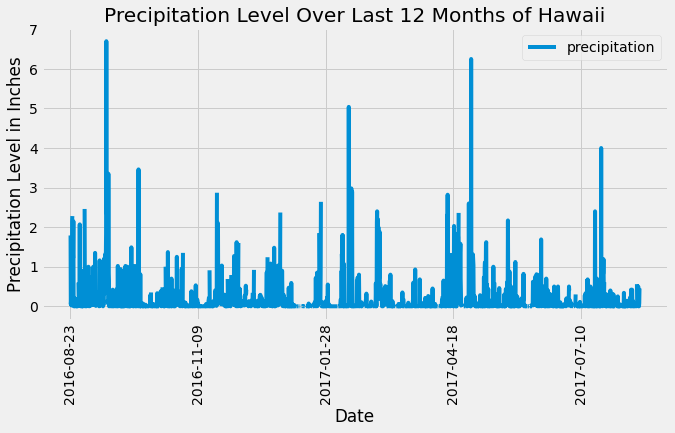

In [38]:
# Perform a query to retrieve the date and precipitation scores
retrieve_precipitation = session.query(hawaii_measurement.date, hawaii_measurement.prcp).filter(hawaii_measurement.date >= last_year_date).all()
retrieve_precipitation

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(retrieve_precipitation, columns=["date", "precipitation"])
precipitation_df

precipitation_df.set_index("date", inplace=True)
precipitation_df

# Sort the dataframe by date
precipitation_df.sort_index(inplace=True)
precipitation_df

# Use Pandas Plotting with Matplotlib to plot the data
fig,ax=plt.subplots()
precipitation_df.plot(ax=ax, rot=90, figsize=(10,5))
ax.set_title("Precipitation Level Over Last 12 Months of Hawaii")
ax.set_ylabel("Precipitation Level in Inches")
ax.set_xlabel("Date")
plt.savefig("Precipitation Level Over Last 12 Months of Hawaii.png")


In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [42]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(hawaii_station.station).count()
print(f'Number of stations:{stations}')

Number of stations:9


In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(hawaii_measurement.station, func.count(hawaii_measurement.station)).\
group_by(hawaii_measurement.station).order_by(func.count(hawaii_measurement.station).desc())
for station in active_stations:
    print(station)
most_active_stations = session.query(hawaii_station.name).filter(hawaii_station.station == active_stations[0][0]).all()
most_active_stations

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


[('WAIHEE 837.5, HI US')]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_records = session.query(func.min(hawaii_measurement.tobs), func.max(hawaii_measurement.tobs),func.avg(hawaii_measurement.tobs)).filter(hawaii_station.station == active_stations[0][0])
print(f'The temperature records are {temp_records[0][0]}, {temp_records[0][1]}, {temp_records[0][2]}')

The temperature records are 53.0, 87.0, 73.09795396419437


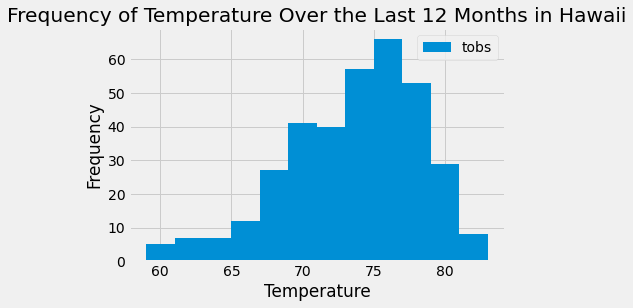

In [55]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_number = session.query(hawaii_measurement.date, hawaii_measurement.tobs).\
filter(hawaii_measurement.station == active_stations[0][0]).filter(hawaii_measurement.date >= last_year_date).all()

#create dataframe
highest_number_df = pd.DataFrame(highest_number)
highest_number_df.head()
highest_number_df.plot(kind="hist", bins=12)
plt.title("Frequency of Temperature Over the Last 12 Months in Hawaii")
plt.xlabel("Temperature")
plt.savefig("Frequency of Temperature Over the Last 12 Months in Hawaii.png")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
